<a href="http://agrum.org" target="blank"><img src="http://agrum.gitlab.io/theme/img/logoAgrum.png" align="left" style="height:100px"/></a><a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This pyAgrum's notebook is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.

In [1]:
import os 

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

from IPython.display import HTML
import io
import base64

class FlowLayout(object):
    '''
    A class / object to display plots in a horizontal / flow layout below a cell 
    
    from https://stackoverflow.com/questions/21754976/ipython-notebook-arrange-plots-horizontally
    '''
    def __init__(self):
        # string buffer for the HTML: initially some CSS; images to be appended
        self.sHtml =  """
        <style>
        .floating-box {
        display: inline-block;
        margin: 0px;
        border: 1px solid #888888;  
        }
        </style>
        """

    def add_plot(self, fig):
        ''' Saves a PNG representation of a Matplotlib Axes object '''
        Bio=io.BytesIO() # bytes buffer for the plot
        #fig = oAxes.get_figure()
        fig.canvas.print_png(Bio) # make a png of the plot in the buffer

        # encode the bytes as string using base 64 
        sB64Img = base64.b64encode(Bio.getvalue()).decode()
        self.sHtml+= (
            '<div class="floating-box">'+ 
            '<img src="data:image/png;base64,{}\n">'.format(sB64Img)+
            '</div>')

    def PassHtmlToCell(self):
        ''' Final step - display the accumulated HTML '''
        display(HTML(self.sHtml))


oPlot = FlowLayout() # create an empty FlowLayout

# Generating the database from a BN

In [2]:
bn=gum.loadBN(os.path.join("res","asia.bif"))
bn

(gum::BayesNet<double>@0x55969a0c3da0) BN{nodes: 8, arcs: 8, domainSize: 256, dim: 36}

In [3]:
# we create a quite large database
gum.generateCSV(bn,os.path.join("out","sample_score.csv"),500000,False)

-1614757.2549099382

# Testing d-separations using chi2 in the database

In [4]:
# do not forget that the generation process above is random : from time to time, the tests my not be correct...
def isIndep(pvalue):
    return pvalue>=0.05

def testIndepFromChi2(learner,var1,var2,kno=[]):
    """
    Just prints the resultat of the chi2
    """
    stat,pvalue=learner.chi2(var1,var2,kno)
    if len(kno)==0:
        print("From Chi2 tests, is '{}' indep from '{}' ==> {}".format(var1,var2,isIndep(pvalue)))
    else:
        print("From Chi2 tests, is '{}' indep from '{}' given {} : {}".format(var1,var2,kno,isIndep(pvalue)))
    
learner=gum.BNLearner(os.path.join("out","sample_score.csv"))

testIndepFromChi2(learner,"visit_to_Asia","smoking")
testIndepFromChi2(learner,"visit_to_Asia","smoking",['tuberculos_or_cancer'])
testIndepFromChi2(learner,"visit_to_Asia","smoking",['positive_XraY'])
testIndepFromChi2(learner,"dyspnoea","smoking")
testIndepFromChi2(learner,"dyspnoea","smoking",["lung_cancer","bronchitis"])


From Chi2 tests, is 'visit_to_Asia' indep from 'smoking' ==> True
From Chi2 tests, is 'visit_to_Asia' indep from 'smoking' given ['tuberculos_or_cancer'] : False
From Chi2 tests, is 'visit_to_Asia' indep from 'smoking' given ['positive_XraY'] : False
From Chi2 tests, is 'dyspnoea' indep from 'smoking' ==> False
From Chi2 tests, is 'dyspnoea' indep from 'smoking' given ['lung_cancer', 'bronchitis'] : True


# Evolution of chi2 p-values w.r.t the size of the database (in Asia)

In [5]:
def consolidationIndepFromChi2(bn,size,lindep,nbr=20):
    """
    Using $nbr$ generated databases of size $size$ from the bn $bn$, 
    consolidate the p-value for a list $lindep$ of conditional independence to test.
    
    return the list of consolidated pValues
    """
    pvalue_cumul=[0.0]*len(lindep)
    for i in range(nbr):
        gum.generateCSV(bn,os.path.join("out","sample_score.csv"),size,False)
        learner=gum.BNLearner(os.path.join("out","sample_score.csv"))
        for i,(var1,var2,kno) in enumerate(lindep):
            stat,pvalue=learner.chi2(var1,var2,kno)
            pvalue_cumul[i]+=pvalue
    return [p/nbr for p in pvalue_cumul]
    
sizes=[50,100,500,1000,2000,5000,10000,20000,50000]
pvalues1,pvalues2,pvalues3,pvalues4,pvalues5,pvalues6=zip(*[consolidationIndepFromChi2(bn,siz,
                                     [("visit_to_Asia","smoking",['tuberculos_or_cancer']),
                                      ("visit_to_Asia","smoking",[]),
                                      ("dyspnoea","smoking",[]),
                                      ("dyspnoea","smoking",["lung_cancer","bronchitis"]),
                                      ("tuberculosis","bronchitis",[]),
                                      ("tuberculosis","bronchitis",["dyspnoea"])])
                                          for siz in sizes])


(gum::BayesNet<double>@0x55969c5876a0) BN{nodes: 8, arcs: 8, domainSize: 256, dim: 36}

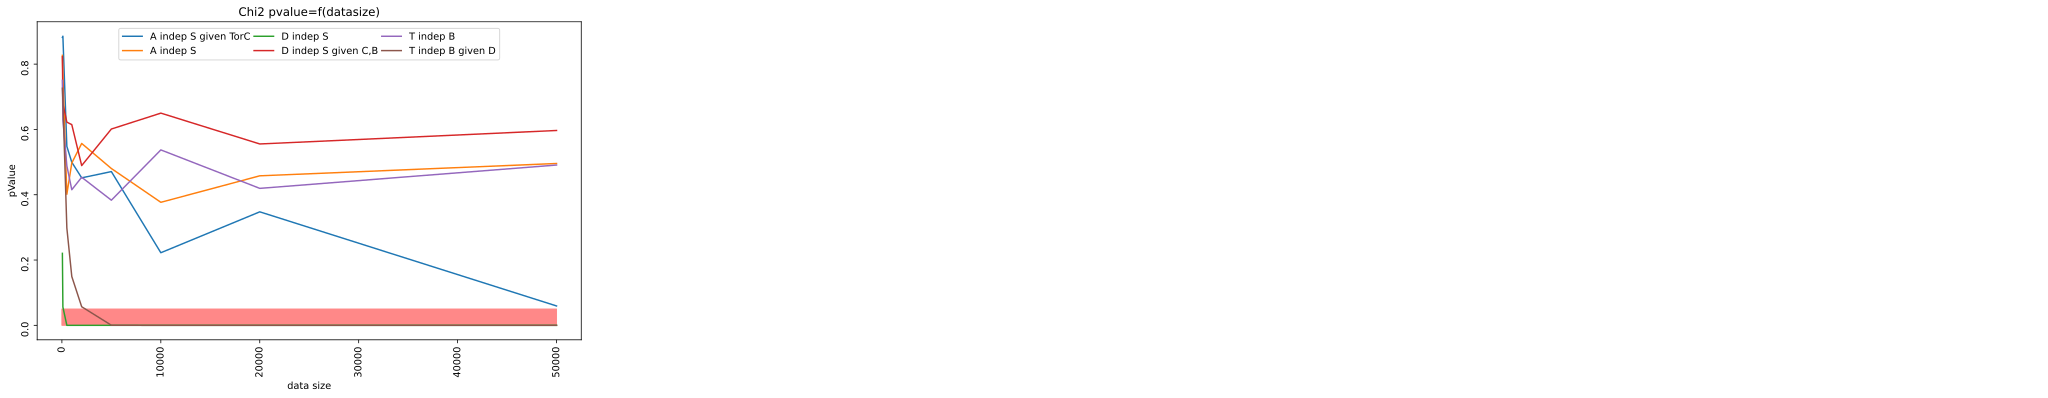

In [6]:
%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig=figure(figsize=(10,6))
ax  = fig.add_subplot(1, 1, 1)

ax.plot(sizes,pvalues1,label="A indep S given TorC")
ax.plot(sizes,pvalues2,label="A indep S")
ax.plot(sizes,pvalues3,label="D indep S")
ax.plot(sizes,pvalues4,label="D indep S given C,B")
ax.plot(sizes,pvalues5,label="T indep B")
ax.plot(sizes,pvalues6,label="T indep B given D")
ax.tick_params(rotation=90)
ax.set_xlabel("data size")
ax.set_ylabel("pValue")
ax.legend(bbox_to_anchor=(0.15, 0.88, 0.7, .102), loc=3,ncol=3, mode="expand", borderaxespad=0.)

rect = patches.Rectangle((0,0),max(sizes),0.05,linewidth=1,edgecolor='#FF8888',facecolor='#FF8888')
ax.add_patch(rect)
ax.annotate("Critical region",xytext=(200000,0.2),xy=(190000,0.05),
            ha="right", va="center",
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=-0.15"
                           ),
            bbox=dict(boxstyle="square", fc="w"))

ax.set_title("Chi2 pvalue=f(datasize)")
oPlot.add_plot(fig)

gum.fastBN("A->T->TorC->X;S->C->TorC->D<-B<-S")

# Testing d-separations using G2 in the database

In [7]:
def testIndepFromG2(learner,var1,var2,kno=[]):
    """
    Just prints the resultat of the G2
    """
    stat,pvalue=learner.G2(var1,var2,kno)
    if len(kno)==0:
        print("From G2 tests, is '{}' indep from '{}' ==> {}".format(var1,var2,isIndep(pvalue)))
    else:
        print("From G2 tests, is '{}' indep from '{}' given {} : {}".format(var1,var2,kno,isIndep(pvalue)))
    
learner=gum.BNLearner(os.path.join("out","sample_score.csv"))

testIndepFromG2(learner,"visit_to_Asia","smoking")
testIndepFromG2(learner,"visit_to_Asia","smoking",['tuberculos_or_cancer'])
testIndepFromG2(learner,"visit_to_Asia","smoking",['positive_XraY'])
testIndepFromG2(learner,"dyspnoea","smoking")
testIndepFromG2(learner,"dyspnoea","smoking",["lung_cancer","bronchitis"])


From G2 tests, is 'visit_to_Asia' indep from 'smoking' ==> True
From G2 tests, is 'visit_to_Asia' indep from 'smoking' given ['tuberculos_or_cancer'] : False
From G2 tests, is 'visit_to_Asia' indep from 'smoking' given ['positive_XraY'] : True
From G2 tests, is 'dyspnoea' indep from 'smoking' ==> False
From G2 tests, is 'dyspnoea' indep from 'smoking' given ['lung_cancer', 'bronchitis'] : True


# Evolution of G2 p-values w.r.t the size of the database (in Asia)

In [8]:
def consolidationIndepFromG2(bn,size,lindep,nbr=20):
    """
    Using $nbr$ generated databases of size $size$ from the bn $bn$, 
    consolidate the p-value for a list $lindep$ of conditional independence to test.
    
    return the list of consolidated pValues
    """
    pvalue_cumul=[0.0]*len(lindep)
    for i in range(nbr):
        gum.generateCSV(bn,os.path.join("out","sample_chi2.csv"),size,False)
        learner=gum.BNLearner(os.path.join("out","sample_chi2.csv"))
        for i,(var1,var2,kno) in enumerate(lindep):
            stat,pvalue=learner.G2(var1,var2,kno)
            pvalue_cumul[i]+=pvalue
    return [p/nbr for p in pvalue_cumul]
    
sizes=[50,100,500,1000,2000,5000,10000,20000,50000,100000,200000]
pvalues1,pvalues2,pvalues3,pvalues4,pvalues5,pvalues6=zip(*[consolidationIndepFromG2(bn,siz,
                                                                                     [("visit_to_Asia","smoking",['tuberculos_or_cancer']),
                                                                                      ("visit_to_Asia","smoking",[]),
                                                                                      ("dyspnoea","smoking",[]),
                                                                                      ("dyspnoea","smoking",["lung_cancer","bronchitis"]),
                                                                                      ("tuberculosis","bronchitis",[]),
                                                                                      ("tuberculosis","bronchitis",["dyspnoea"])])
                                                            for siz in sizes])

(gum::BayesNet<double>@0x55969cae8370) BN{nodes: 8, arcs: 8, domainSize: 256, dim: 36}

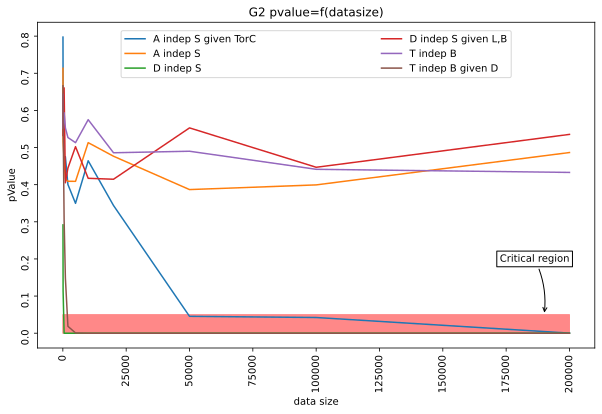

In [9]:
fig=figure(figsize=(10,6))
ax  = fig.add_subplot(1, 1, 1)

ax.plot(sizes,pvalues1,label="A indep S given TorC")
ax.plot(sizes,pvalues2,label="A indep S")
ax.plot(sizes,pvalues3,label="D indep S")
ax.plot(sizes,pvalues4,label="D indep S given L,B")
ax.plot(sizes,pvalues5,label="T indep B")
ax.plot(sizes,pvalues6,label="T indep B given D")
ax.tick_params(rotation=90)
ax.set_xlabel("data size")
ax.set_ylabel("pValue")
ax.legend(bbox_to_anchor=(0.15, 0.83, 0.7, .102), loc=3,ncol=2, mode="expand", borderaxespad=0.)

rect = patches.Rectangle((0,0),max(sizes),0.05,linewidth=1,edgecolor='#FF8888',facecolor='#FF8888')
ax.add_patch(rect)
ax.annotate("Critical region",xytext=(200000,0.2),xy=(190000,0.05),
            ha="right", va="center",
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=-0.15"
                           ),
            bbox=dict(boxstyle="square", fc="w"))

ax.set_title("G2 pvalue=f(datasize)")
oPlot.add_plot(fig)

gum.fastBN("A->T->TorC->X;S->C->TorC->D<-B<-S")

# Conditional joint log-likelihood
With BNLearner, you can also check the joint (condtional) log-likelihood in the base

In [10]:
bn

(gum::BayesNet<double>@0x55969a0c3da0) BN{nodes: 8, arcs: 8, domainSize: 256, dim: 36}

In [11]:
siz=10000
gum.generateCSV(bn,os.path.join("out","sample_score.csv"),siz,False)
learner=gum.BNLearner(os.path.join("out","sample_score.csv"))

def affLL(learner,s1,s2=[]):
    if len(s2)==0:
        print("{} : {}".format(s1,learner.logLikelihood(s1)))
    else:
        print("{}|{} : {}".format(s1,s2,learner.logLikelihood(s1,s2)))
        
def dsepByLL(learner,x,y,z): # is X indep of Y given Z ?
    lxy_z=learner.logLikelihood([x,y],[z])
    lx_z=learner.logLikelihood([x],[z])
    ly_z=learner.logLikelihood([y],[z])
    print("{} indep {} given {} : {}".format(x,y,z,lxy_z-lx_z-ly_z))

print("Condional Joint LogLikelihood")
affLL(learner,["lung_cancer","bronchitis","smoking"])
affLL(learner,["smoking"])
affLL(learner,["lung_cancer","bronchitis"],["smoking"])

print("--------------")
print("LL indep test")
dsepByLL(learner,"lung_cancer","bronchitis","smoking")
dsepByLL(learner,"tuberculos_or_cancer","bronchitis","dyspnoea")

Condional Joint LogLikelihood
['lung_cancer', 'bronchitis', 'smoking'] : -21937.724653903235
['smoking'] : -9999.989612593228
['lung_cancer', 'bronchitis']|['smoking'] : -11937.735041310007
--------------
LL indep test
lung_cancer indep bronchitis given smoking : 0.08996565073903184
tuberculos_or_cancer indep bronchitis given dyspnoea : 113.297325729769


# Evolution of conditional log-likelihood w.r.t the size of the database (in Asia)

In [12]:
def consolidationIndepFromLL(bn,size,lindep,nbr=20):
    """
    Using $nbr$ generated databases of size $size$ from the bn $bn$, 
    consolidate the logLikelihoos for a list $lindep$ of conditional independence to test.
    
    return the list of consolidated pValues
    """
    LL_cumul=[0.0]*len(lindep)
    for i in range(nbr):
        gum.generateCSV(bn,os.path.join("out","sample_score.csv"),size,False)
        learner=gum.BNLearner(os.path.join("out","sample_score.csv"))
        for i,(var1,var2,kno) in enumerate(lindep):
            LL12=learner.logLikelihood([var1,var2],kno)
            LL1=learner.logLikelihood([var1],kno)
            LL2=learner.logLikelihood([var2],kno)
            LL_cumul[i]+=(LL12-LL1-LL2)/size
    return [p/nbr for p in LL_cumul]
    
sizes=[50,100,500,1000,2000,5000,10000,20000,50000,100000,200000]
LL1,LL2,LL3,LL4,LL5,LL6=zip(*[consolidationIndepFromLL(bn,siz,
                                     [("visit_to_Asia","smoking",['tuberculos_or_cancer']),
                                      ("visit_to_Asia","smoking",[]),
                                      ("dyspnoea","smoking",[]),
                                      ("dyspnoea","smoking",["lung_cancer","bronchitis"]),
                                      ("tuberculosis","bronchitis",[]),
                                      ("tuberculosis","bronchitis",["dyspnoea"])])
                                          for siz in sizes])




(gum::BayesNet<double>@0x55969cb2d080) BN{nodes: 8, arcs: 8, domainSize: 256, dim: 36}

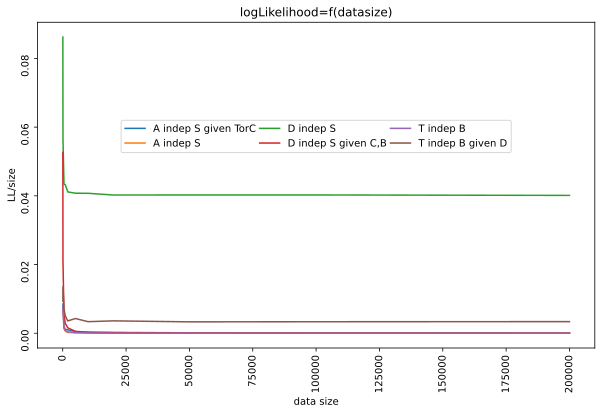

In [13]:
%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig=figure(figsize=(10,6))
ax  = fig.add_subplot(1, 1, 1)

ax.plot(sizes,LL1,label="A indep S given TorC")
ax.plot(sizes,LL2,label="A indep S")
ax.plot(sizes,LL3,label="D indep S")
ax.plot(sizes,LL4,label="D indep S given C,B")
ax.plot(sizes,LL5,label="T indep B")
ax.plot(sizes,LL6,label="T indep B given D")
ax.tick_params(rotation=90)
ax.set_xlabel("data size")
ax.set_ylabel("LL/size")
ax.legend(bbox_to_anchor=(0.15, 0.6, 0.7, .102), loc=3,ncol=3, mode="expand", borderaxespad=0.)

ax.set_title("logLikelihood=f(datasize)")
oPlot.add_plot(fig)

gum.fastBN("A->T->TorC->X;S->C->TorC->D<-B<-S")

# Comparing the scores


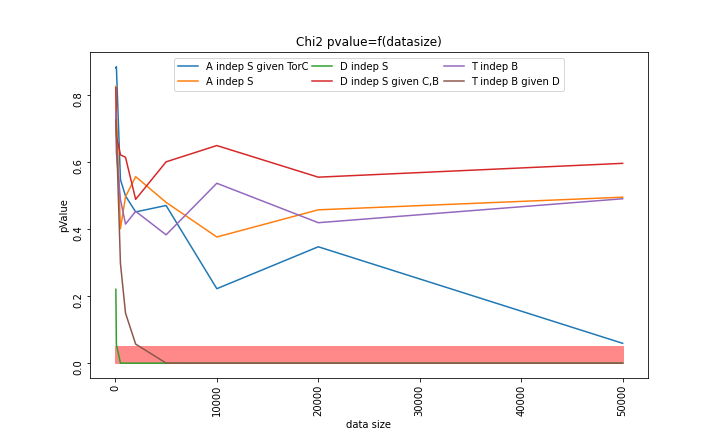
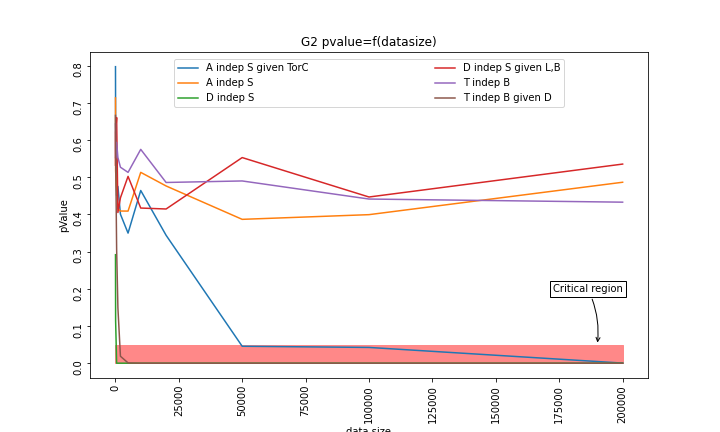
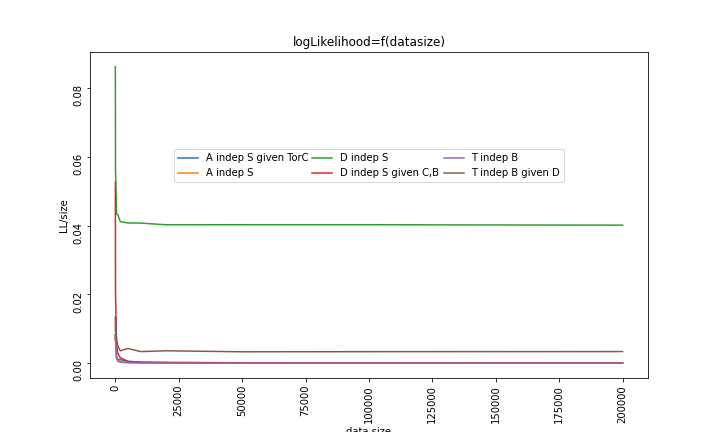

In [14]:
oPlot.PassHtmlToCell()